In [27]:
import h5py
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten
from keras.utils import to_categorical
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# This make sure the input shape is: (number of samples, width, height, channels)
K.set_image_dim_ordering( 'tf' )

# Load in preprocessed data
with h5py.File('X.h5', 'r') as hf:
    X = hf['X_h5'][:]
with h5py.File('y.h5', 'r') as hf:
    y = hf['y_h5'][:]

# Get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle = True)

# Prepare images to correct shape for Keras model
X_train = X_train.reshape(X_train.shape[0], 160, 120, 1)
X_test= X_test.reshape(X_test.shape[0], 160, 120, 1)
y_train = to_categorical(y_train).astype('int32')
y_test = to_categorical(y_test).astype('int32')

# Check data to see if everything is ok
print(" 'X' matrix/input ")
print(X_train.shape)
print(X_train[0][0], '\n')
print(" 'y' label/output ")
print(y_train.shape)
print(y_train)

/home/tmbluth/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


 'X' matrix/input 
(17939, 160, 120, 1)
[[ 0.12156863]
 [ 0.11764706]
 [ 0.10196079]
 [ 0.10196079]
 [ 0.10588235]
 [ 0.10196079]
 [ 0.10588235]
 [ 0.10980392]
 [ 0.11372549]
 [ 0.11372549]
 [ 0.11372549]
 [ 0.11372549]
 [ 0.10588235]
 [ 0.10980392]
 [ 0.10980392]
 [ 0.10588235]
 [ 0.10588235]
 [ 0.11372549]
 [ 0.10980392]
 [ 0.10980392]
 [ 0.11764706]
 [ 0.11764706]
 [ 0.11372549]
 [ 0.1254902 ]
 [ 0.12941177]
 [ 0.12941177]
 [ 0.1254902 ]
 [ 0.13333334]
 [ 0.13725491]
 [ 0.13725491]
 [ 0.13725491]
 [ 0.14117648]
 [ 0.14509805]
 [ 0.14509805]
 [ 0.15294118]
 [ 0.15294118]
 [ 0.15294118]
 [ 0.15294118]
 [ 0.16078432]
 [ 0.16078432]
 [ 0.15686275]
 [ 0.16078432]
 [ 0.16470589]
 [ 0.17647059]
 [ 0.18431373]
 [ 0.18431373]
 [ 0.18039216]
 [ 0.17254902]
 [ 0.14901961]
 [ 0.1254902 ]
 [ 0.13333334]
 [ 0.2       ]
 [ 0.28235295]
 [ 0.36078432]
 [ 0.47843137]
 [ 0.59607846]
 [ 0.67450982]
 [ 0.79607844]
 [ 0.90588236]
 [ 0.89411765]
 [ 0.9254902 ]
 [ 0.94509804]
 [ 0.86274511]
 [ 0.82745099]


In [2]:
# This is a cosine annealing learning rate scheduler with restarts: Copied from Jeremy Jordan
from keras.callbacks import Callback
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [6]:
batch_size = 32

# Use next line if not doing cosine annealing
# early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

schedule = SGDRScheduler(min_lr=1e-4,
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(X_train.shape[0]/batch_size),
                         lr_decay=0.8,
                         cycle_length=5,
                         mult_factor=2)

def DD_VGG():
    model = Sequential()
    # Use Batch Normalization for every conv and dense layers
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (160, 120, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.33))
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation = 'softmax')) # Sigmoid for log loss?
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model

driver_model = DD_VGG()
driver_hist = driver_model.fit(X_train, y_train, epochs=15, batch_size=batch_size, verbose=1,
                               validation_split=0.2, callbacks=[schedule])

Train on 14351 samples, validate on 3588 samples
Epoch 1/15
14351/14351 [==============================] - 264s 18ms/step - loss: 1.3081 - acc: 0.5353 - val_loss: 1.8398 - val_acc: 0.5730
Epoch 2/15
14351/14351 [==============================] - 264s 18ms/step - loss: 0.3245 - acc: 0.8951 - val_loss: 0.0991 - val_acc: 0.9707
Epoch 3/15
14351/14351 [==============================] - 263s 18ms/step - loss: 0.1506 - acc: 0.9525 - val_loss: 0.0638 - val_acc: 0.9813
Epoch 4/15
14351/14351 [==============================] - 263s 18ms/step - loss: 0.0677 - acc: 0.9789 - val_loss: 0.0404 - val_acc: 0.9900
Epoch 5/15
14351/14351 [==============================] - 264s 18ms/step - loss: 0.0363 - acc: 0.9888 - val_loss: 0.0318 - val_acc: 0.9928
Epoch 6/15
14351/14351 [==============================] - 264s 18ms/step - loss: 0.1843 - acc: 0.9388 - val_loss: 0.0704 - val_acc: 0.9797
Epoch 7/15
14351/14351 [==============================] - 263s 18ms/step - loss: 0.0836 - acc: 0.9721 - val_loss: 0.0

In [7]:
driver_model.save('./driver_model.h5')
# driver_model = load_model('./driver_model.h5')

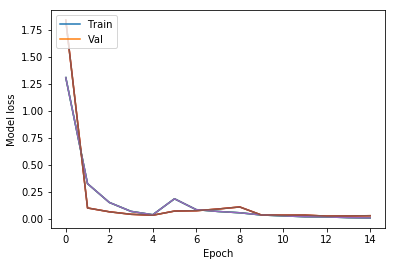

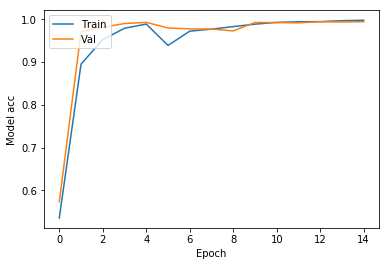

In [11]:
def plot_model(model_hist, train_metric, val_metric):
    plt.plot(model_hist[train_metric])
    plt.plot(model_hist[val_metric])
    plt.ylabel('Model ' + str(train_metric))
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_model(driver_hist.history, 'loss', 'val_loss')
plot_model(driver_hist.history, 'acc', 'val_acc')

In [28]:
# Get predictions and make them into vector of 0 to 9
test_pred = driver_model.predict(X_test)
test_pred2 = np.argmax(test_pred, axis = 1)

# Change dummy code matrix back to vector of 0 to 9
y_test2 = np.argmax(y_test, axis = 1)

# Get performance
print(confusion_matrix(y_test2, test_pred2))
print("Test set accuracy is: %s" % accuracy_score(y_test2, test_pred2))

[[512   1   0   0   0   0   0   0   1   0]
 [  0 474   0   0   0   0   0   0   0   0]
 [  0   0 438   0   0   0   1   0   0   0]
 [  0   0   0 488   0   0   0   0   0   0]
 [  0   0   0   2 446   0   0   0   0   0]
 [  0   0   0   0   0 466   2   0   0   0]
 [  0   0   0   0   0   0 460   0   0   0]
 [  0   0   0   0   1   0   1 389   0   0]
 [  0   0   1   0   0   0   0   1 368   2]
 [  0   0   0   0   0   0   0   0   2 429]]
Test set accuracy is: 0.996655518395


In [19]:
# Free up memory for submission data
%reset

# Re-import needed modules
import glob
import os
import numpy as np
from PIL import Image
from keras.models import load_model
import pandas as pd

submission_data = []
filenames = []

img_list = sorted(glob.glob("/home/tmbluth/Documents/GitHub/Distracted-Drivers-Detection/test/*.jpg"))
for file in img_list:
     # Open each image and convert to black and white
    img = Image.open(file)
    filenames.append(os.path.basename(img.filename))
    img = img.convert('L')
    # Get image height and width to divide each by 4 (save memory)
    # thumbnail is an in-place operation
    img.thumbnail((img.size[0]/4, img.size[1]/4), Image.ANTIALIAS)
    # Make into numpy array divided by the max to get 0 to 1 normalization
    img = np.array(img.getdata(), dtype = 'float32').reshape(img.size[0], img.size[1]) / 255
    submission_data.append(img)
    
print("Number of test images: %s" % len(submission_data))

# Make list into numpy array and reshape to feed into model
submission_data = np.array(submission_data, dtype = 'float32')
submission_data = submission_data.reshape(submission_data.shape[0], 160, 120, 1)

print(filenames[:5])

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Number of test images: 79726
[[[[ 0.20784314]
   [ 0.20784314]
   [ 0.20392157]
   ..., 
   [ 0.4627451 ]
   [ 0.4627451 ]
   [ 0.47450981]]

  [[ 0.51372552]
   [ 0.56078434]
   [ 0.60784316]
   ..., 
   [ 0.89411765]
   [ 0.89019608]
   [ 0.89411765]]

  [[ 0.9137255 ]
   [ 0.9137255 ]
   [ 0.87843138]
   ..., 
   [ 0.8392157 ]
   [ 0.77254903]
   [ 0.58823532]]

  ..., 
  [[ 0.09411765]
   [ 0.08235294]
   [ 0.07058824]
   ..., 
   [ 0.04313726]
   [ 0.04705882]
   [ 0.02745098]]

  [[ 0.09411765]
   [ 0.37254903]
   [ 0.3882353 ]
   ..., 
   [ 0.16470589]
   [ 0.16862746]
   [ 0.18039216]]

  [[ 0.18431373]
   [ 0.19215687]
   [ 0.22745098]
   ..., 
   [ 0.05098039]
   [ 0.07058824]
   [ 0.10196079]]]


 [[[ 0.17254902]
   [ 0.30588236]
   [ 0.3137255 ]
   ..., 
   [ 0.93725491]
   [ 0.90980393]
   [ 0.9254902 ]]

  [[ 0.95686275]
   [ 0.95686275]
   [ 0.94117647]
   ..., 
   [ 0.92156863]
   [ 0.9137255 ]
   [ 0.86666

In [21]:
# Load in model and use it to predict
# driver_model = load_model('./driver_model.h5')

# Get log probabilities
kaggle_log_probs = driver_model.predict(submission_data)
kaggle_log_probs = pd.DataFrame(kaggle_log_probs, index = filenames, columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])

kaggle_log_probs.to_csv('./kaggle_submission.csv', sep=',', encoding='utf-8')

In [22]:
kaggle_log_probs

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_1.jpg,1.677748e-10,5.003683e-07,9.438826e-02,1.614166e-06,1.161051e-08,9.055930e-01,2.184783e-08,1.640248e-05,2.337407e-08,1.474562e-07
img_10.jpg,1.875779e-01,1.264999e-06,1.185985e-03,6.081099e-03,7.780300e-01,2.125389e-02,3.354812e-05,5.500358e-03,2.937394e-04,4.220421e-05
img_100.jpg,1.683963e-04,9.983845e-01,2.283335e-06,1.466183e-06,1.501436e-08,1.522593e-05,3.759487e-05,1.697321e-04,6.326819e-04,5.881301e-04
img_1000.jpg,2.790737e-07,4.872329e-07,1.747715e-07,9.071917e-09,1.731309e-07,3.446075e-07,3.180628e-05,2.777127e-06,9.999633e-01,6.649790e-07
img_100000.jpg,1.483383e-02,3.907291e-06,8.622946e-07,9.715524e-01,8.515755e-06,1.357298e-02,5.054212e-08,2.164191e-08,6.571065e-06,2.098582e-05
img_100001.jpg,5.576673e-05,1.180351e-05,1.801945e-04,2.649682e-01,4.478481e-02,5.034888e-01,2.957019e-04,3.364613e-05,1.861547e-01,2.645914e-05
img_100002.jpg,8.263968e-05,2.982100e-03,2.394840e-07,5.794090e-09,1.474315e-05,3.696170e-04,9.957076e-01,4.499988e-09,1.134148e-06,8.418839e-04
img_100003.jpg,7.524583e-06,4.935368e-04,3.356559e-05,7.339881e-06,6.221001e-06,1.512247e-05,4.623963e-08,2.544621e-05,9.961209e-01,3.290343e-03
img_100004.jpg,7.659302e-03,1.002787e-06,2.689831e-05,5.823994e-06,1.902294e-01,1.475250e-03,6.443800e-01,3.176585e-05,1.561858e-01,4.600275e-06
img_100005.jpg,1.163573e-18,1.326007e-10,2.365551e-16,1.309987e-26,2.705826e-22,9.458334e-08,2.670526e-25,9.999999e-01,4.578249e-22,4.817457e-23
